# No-glue-code

In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/Cambdrige`


In [2]:
# The statistical inference frame-work we will use
using LogDensityProblems
using LogDensityProblemsAD
using DynamicPPL
using ForwardDiff
using Random
using LinearAlgebra

#Plotting
using PyPlot

#What we are tweaking
using Revise
using AdvancedHMC
using Turing
using MCMCChains

[ Info: Precompiling AdvancedHMC [0bf59076-c3b1-5ca4-86bd-e02cd72cde3d]
[ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]


## Model

In [3]:
# Just a simple Neal Funnel
d = 21
@model function funnel()
    θ ~ Normal(0, 3)
    z ~ MvNormal(zeros(d-1), exp(θ)*I)
    x ~ MvNormal(z, I)
end

funnel (generic function with 2 methods)

In [4]:
Random.seed!(1)
(;x) = rand(funnel() | (θ=0,))
funnel_model = funnel() | (;x)

Model{typeof(funnel), (), (), (), Tuple{}, Tuple{}, ConditionContext{NamedTuple{(:x,), Tuple{Vector{Float64}}}, DefaultContext}}(funnel, NamedTuple(), NamedTuple(), ConditionContext((x = [1.2142074831535152, 1.23371919965455, -0.8480146960461767, 0.1600994648479841, 1.9180385508479283, -3.401523464506408, -0.0957684186471088, 0.6734622629464286, -3.2749467689509633, -1.6760091758453226, 1.9567202902549736, 0.1136169088905351, 0.11117896909388916, -0.5373922347882832, -0.12436857036298687, -1.2901071061088532, 1.702584517514787, -0.44460133117954226, 1.0818722439221686, 1.2208011493237483],), DefaultContext()))

## Sampling

In [10]:
nadapts=500 
TAP=0.95
nuts = AdvancedHMC.NUTS(nadapts, TAP; init_ϵ=0.1)

NUTS(500, 0.95, 10, 1000.0, 0.1, nothing, Leapfrog, AdvancedHMC.NUTS_kernel, AdvancedHMC.var"#adaptor#36"{Float64}(0.95))

In [11]:
ϵ=0.1
n_leapfrog=20
hmc = AdvancedHMC.HMC(ϵ, n_leapfrog)

HMC(0.1, 20, nothing, Leapfrog, AdvancedHMC.var"#kernel#37"{Int64}(20), AdvancedHMC.Adaptation.NoAdaptation())

In [26]:
n_adapts = 500
TAP = 0.95
λ = 0.1 * 10
#ϵ = 0.1
hmcda = AdvancedHMC.HMCDA(n_adapts, TAP, λ; ϵ = 0.1)

HMCDA(500, 0.95, 1.0, 0.1, nothing, Leapfrog, AdvancedHMC.var"#kernel#39"{Float64}(1.0), AdvancedHMC.var"#adaptor#41"{Float64}(0.95))

In [13]:
nuts_samples = sample(funnel_model, nuts, 5000; chain_type=MCMCChains.Chains)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Chains MCMC chain (5000×34×1 Array{Real, 3}):

Iterations        = 1:1:5000
Number of chains  = 1
Samples per chain = 5000
parameters        = θ, z1, z2, z3, z4, z5, z6, z7, z8, z9, z10, z11, z12, z13, z14, z15, z16, z17, z18, z19, z20
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, is_adapt

Summary Statistics
  parameters      mean       std      mcse    ess_bulk      rhat   ess_per_sec ⋯
      Symbol   Float64   Float64   Float64        Real   Float64       Missing ⋯

           θ   -0.1180    0.8918    0.0516    497.3398    1.0002       missing ⋯
          z1    0.5920    0.7269    0.0124   3607.5608    1.0000       missing ⋯
          z2    0.5912    0.7400    0.0127   3386.0620    1.0005       missing ⋯
          z3   -0.4256    0.7000    0.0098   5323.0029    1.0004       missing ⋯
          z4    0.0743    0.6814    0.0073 

┌ Warning: Tail ESS calculation failed: OverflowError("4750 * 4503599627370496 overflowed for type Int64")
└ @ MCMCChains ~/.julia/packages/MCMCChains/OVsxE/src/stats.jl:319


In [24]:
hmc_samples = sample(funnel_model, hmc, 5000; chain_type=MCMCChains.Chains)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Chains MCMC chain (5000×32×1 Array{Real, 3}):

Iterations        = 1:1:5000
Number of chains  = 1
Samples per chain = 5000
parameters        = θ, z1, z2, z3, z4, z5, z6, z7, z8, z9, z10, z11, z12, z13, z14, z15, z16, z17, z18, z19, z20
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, numerical_error, step_size, nom_step_size, is_adapt

Summary Statistics
  parameters      mean       std      mcse     ess_bulk      rhat   ess_per_se ⋯
      Symbol   Float64   Float64   Float64         Real   Float64       Missin ⋯

           θ   -0.0750    0.8795    0.0490     551.7009    1.0008       missin ⋯
          z1    0.6041    0.7343    0.0095    6000.9070    1.0004       missin ⋯
          z2    0.6107    0.7176    0.0089    6785.2022    1.0028       missin ⋯
          z3   -0.4193    0.7077    0.0060   14325.0623    1.0002       missin ⋯
          z4    0.0834    0.6742    0.0050   18494.8500    1.0072       missin ⋯
    

┌ Warning: Tail ESS calculation failed: OverflowError("4750 * 4503599627370496 overflowed for type Int64")
└ @ MCMCChains ~/.julia/packages/MCMCChains/OVsxE/src/stats.jl:319


In [27]:
hmcda_samples = sample(funnel_model, hmcda, 5000; chain_type=MCMCChains.Chains)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (5000×32×1 Array{Real, 3}):

Iterations        = 1:1:5000
Number of chains  = 1
Samples per chain = 5000
parameters        = θ, z1, z2, z3, z4, z5, z6, z7, z8, z9, z10, z11, z12, z13, z14, z15, z16, z17, z18, z19, z20
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, numerical_error, step_size, nom_step_size, is_adapt

Summary Statistics
  parameters      mean       std      mcse    ess_bulk      rhat   ess_per_sec ⋯
      Symbol   Float64   Float64   Float64        Real   Float64       Missing ⋯

           θ   -0.1591    0.9362    0.0666    348.6466    1.0009       missing ⋯
          z1    0.5591    0.7099    0.0163   1920.3022    1.0007       missing ⋯
          z2    0.6117    0.7315    0.0163   2095.0534    1.0014       missing ⋯
          z3   -0.4060    0.7099    0.0152   2243.3603    0.9999       missing ⋯
          z4    0.0829    0.6762    0.0121   3154.9764    1.0003       missing ⋯
    

┌ Warning: Tail ESS calculation failed: OverflowError("4750 * 4503599627370496 overflowed for type Int64")
└ @ MCMCChains ~/.julia/packages/MCMCChains/OVsxE/src/stats.jl:319


### Plotting

In [29]:
theta_nuts = Vector(nuts_samples["θ"][:, 1])
x10_nuts =Vector(nuts_samples["z10"][:, 1]);

In [35]:
theta_hmc = Vector(hmc_samples["θ"][:, 1])
x10_hmc =Vector(hmc_samples["z10"][:, 1]);

In [32]:
theta_hmcda = Vector(hmcda_samples["θ"][:, 1])
x10_hmcda =Vector(hmcda_samples["z10"][:, 1]);

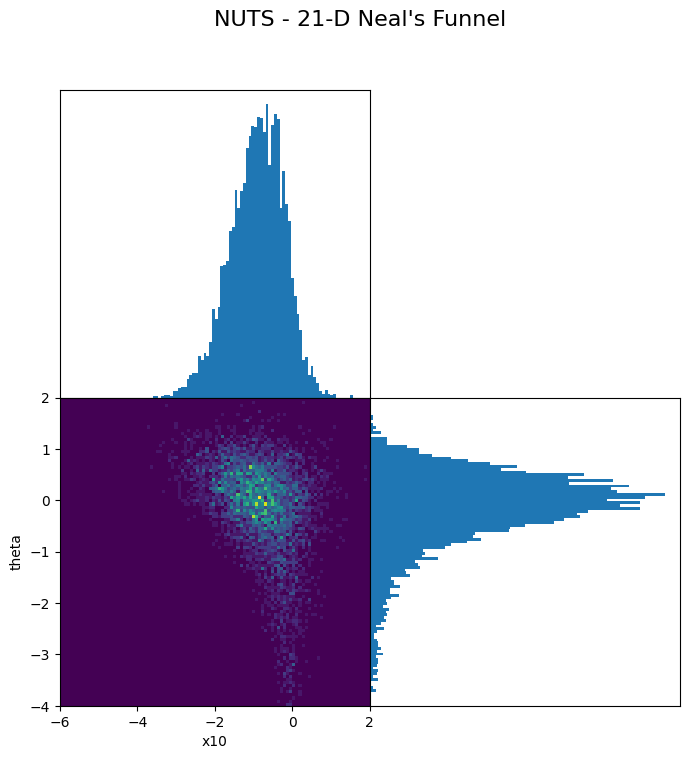

In [39]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("NUTS - 21-D Neal's Funnel", fontsize=16)

fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_nuts, bins=100, range=[-6,2])
axis[1,1].set_yticks([])

axis[2,2].hist(theta_nuts, bins=100, orientation="horizontal", range=[-4, 2])
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(x10_nuts, theta_nuts, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta");

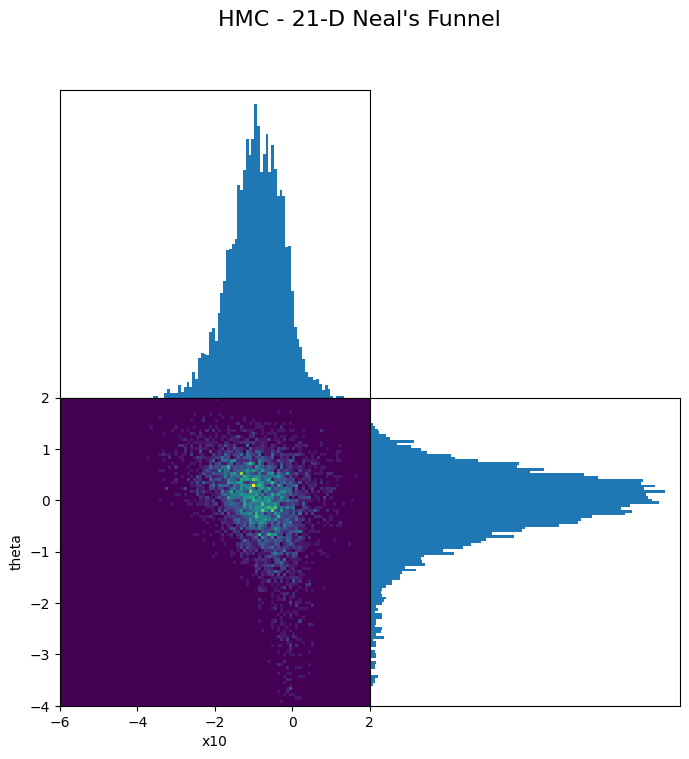

In [42]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("HMC - 21-D Neal's Funnel", fontsize=16)

fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_hmc, bins=100, range=[-6,2])
axis[1,1].set_yticks([])

axis[2,2].hist(theta_hmc, bins=100, orientation="horizontal", range=[-4, 2])
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(x10_hmc, theta_hmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta");

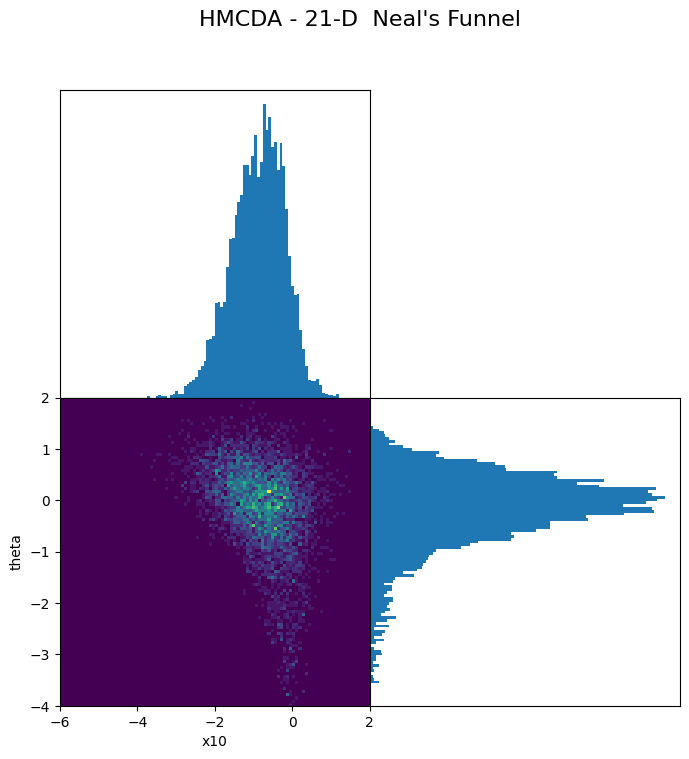

In [41]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("HMCDA - 21-D  Neal's Funnel", fontsize=16)

fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_hmcda, bins=100, range=[-6,2])
axis[1,1].set_yticks([])

axis[2,2].hist(theta_hmcda, bins=100, orientation="horizontal", range=[-4, 2])
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(x10_hmcda, theta_hmcda, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta");

## Sampling w Turing

In [ ]:
using Turing

In [ ]:
TAP = 0.95
nadapts = 300
spl = Turing.NUTS(nadapts, TAP)

In [ ]:
Turing.sample(funnel_model, spl, 50_000, progress=true; save_state=true)